# 0.5 Preparação do Dataset (Google Drive)

Nesta versão, o dataset fica armazenado no **Google Drive** do usuário, na mesma pasta
onde está o notebook. Assim, evitamos dependência de token/credenciais do Kaggle
e reduzimos pontos de falha (como upload e autenticação).

## Como organizar no Drive (obrigatório)
Coloque o dataset **extraído** (não zip) em uma pasta, por exemplo:

MyDrive/Ligia_compviz

E dentro da pasta Ligia_compviz estaria:
*   competicao.ipynb
* ligia-compviz <- (DATA_DIR)

⚠️ Observação:
- Cada usuário precisa ter o dataset local no próprio Drive.


In [ ]:
# 0.5.1 Montar Google Drive

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## 0.5.2 Definir o caminho do dataset (DATA_DIR)

Defina abaixo a pasta no Drive onde você colocou o dataset extraído.
Recomendação: manter o notebook e a pasta do dataset no mesmo diretório (organização do projeto).


In [ ]:
# 0.5.2 Defina o caminho base do seu projeto no Drive (ajuste só essa linha)

PROJECT_DIR = "/content/drive/MyDrive/Ligia_compviz"  # <- ajuste para sua pasta
DATA_DIR = f"{PROJECT_DIR}/ligia-compviz"            # <- pasta do dataset extraído

print("PROJECT_DIR:", PROJECT_DIR)
print("DATA_DIR:", DATA_DIR)


PROJECT_DIR: /content/drive/MyDrive/Ligia_compviz
DATA_DIR: /content/drive/MyDrive/Ligia_compviz/ligia-compviz


## 0.5.3 Sanity Check (estrutura do dataset)

Validamos se os arquivos/pastas essenciais existem antes de seguir.
Isso evita erros comuns como:
- dataset na pasta errada
- dataset ainda zipado
- estrutura diferente do esperado

In [ ]:
# 0.5.3 Sanity check enxuto

import os

expected = {
    "train.csv": os.path.join(DATA_DIR, "train.csv"),
    "test.csv": os.path.join(DATA_DIR, "test.csv"),
    "NORMAL dir": os.path.join(DATA_DIR, "train", "train", "NORMAL"),
    "PNEUMONIA dir": os.path.join(DATA_DIR, "train", "train", "PNEUMONIA"),
    "test_images dir": os.path.join(DATA_DIR, "test_images", "test_images"),
}

for name, path in expected.items():
    assert os.path.exists(path), f"❌ Não encontrado: {name} -> {path}"
print("✅ Estrutura mínima OK.")

# Contagens rápidas
n_norm = len(os.listdir(expected["NORMAL dir"]))
n_pne  = len(os.listdir(expected["PNEUMONIA dir"]))
n_test = len(os.listdir(expected["test_images dir"]))

print(f"📊 Contagens: NORMAL={n_norm} | PNEUMONIA={n_pne} | TEST={n_test}")
print("✅ DATA_DIR pronto:", DATA_DIR)


✅ Estrutura mínima OK.
📊 Contagens: NORMAL=1349 | PNEUMONIA=3883 | TEST=624
✅ DATA_DIR pronto: /content/drive/MyDrive/Ligia_compviz/ligia-compviz


# 1. Setup Experimental

Nesta seção realizamos a configuração inicial do ambiente experimental.

O objetivo é:

- Garantir **reprodutibilidade científica**
- Importar bibliotecas necessárias
- Definir o dispositivo de execução (CPU/GPU)
- Estruturar os caminhos do dataset

Seguindo as diretrizes do edital, fixamos a semente aleatória (seed = 42) para assegurar consistência nos resultados ao longo das execuções.

Essa etapa é essencial para garantir:
- Controle experimental
- Robustez metodológica
- Integridade científica


In [ ]:
# Bibliotecas Fundamentais
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

# Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Métricas
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


## 1.1 Reprodutibilidade

Para garantir a consistência dos experimentos, fixamos a semente aleatória em todas as bibliotecas relevantes.

Isso evita variações causadas por:

- Inicialização aleatória dos pesos
- Embaralhamento de dados
- Operações internas do backend CUDA

Essa prática é essencial em experimentos científicos e será mantida ao longo de todo o projeto.


In [ ]:
# Reprodutibilidade
SEED = 42

def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)


## 1.2 Configuração do Dispositivo

O treinamento será realizado utilizando GPU quando disponível,
de forma a acelerar o processo de otimização do modelo.

Caso GPU não esteja disponível, o código executará automaticamente em CPU.


In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Executando em: {device}")


Executando em: cuda


## 1.3 Estrutura do Dataset

O dataset está organizado da seguinte forma:

- `test_images/test_images/` → imagens do conjunto de teste (sem rótulos)
- `train/train/NORMAL/` → imagens normais
- `train/train/PNEUMONIA/` → imagens com pneumonia
- `train/train.csv` → arquivo auxiliar
- `train/test.csv` → template de submissão

As imagens de treino estão separadas por classe em pastas distintas,
permitindo a construção manual de um DataFrame estruturado.


In [ ]:
# Paths do Dataset

TEST_IMG_DIR  = os.path.join(DATA_DIR, "test_images/test_images")
TRAIN_ROOT    = os.path.join(DATA_DIR, "train")
TRAIN_IMG_DIR = os.path.join(TRAIN_ROOT, "train")

TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
TEST_CSV  = os.path.join(DATA_DIR, "test.csv")

print("Test images:", TEST_IMG_DIR)
print("Train images:", TRAIN_IMG_DIR)


Test images: /content/drive/MyDrive/Ligia_compviz/ligia-compviz/test_images/test_images
Train images: /content/drive/MyDrive/Ligia_compviz/ligia-compviz/train/train


## 1.4 Verificação dos Caminhos (Sanity Check)

Antes de iniciar qualquer análise ou treinamento, validamos se os diretórios esperados realmente existem e se contêm arquivos.

Essa etapa evita erros comuns, como:
- caminho incorreto no `/kaggle/input/`
- pastas vazias por configuração errada do dataset
- divergências na estrutura de diretórios


In [ ]:
print("TEST_IMG_DIR existe?", os.path.exists(TEST_IMG_DIR))
print("TRAIN_IMG_DIR existe?", os.path.exists(TRAIN_IMG_DIR))

print("\nAmostra de arquivos em test_images:", os.listdir(TEST_IMG_DIR)[:5])
print("Subpastas dentro de train/train:", os.listdir(TRAIN_IMG_DIR))

# contagem rápida
print("\nQtd test_images:", len(os.listdir(TEST_IMG_DIR)))
print("Qtd pneumonia:", len(os.listdir(os.path.join(TRAIN_IMG_DIR, "PNEUMONIA"))))
print("Qtd normal:", len(os.listdir(os.path.join(TRAIN_IMG_DIR, "NORMAL"))))


TEST_IMG_DIR existe? True
TRAIN_IMG_DIR existe? True

Amostra de arquivos em test_images: ['img_0028.jpeg', 'img_0009.jpeg', 'img_0033.jpeg', 'img_0006.jpeg', 'img_0032.jpeg']
Subpastas dentro de train/train: ['PNEUMONIA', 'NORMAL']

Qtd test_images: 624
Qtd pneumonia: 3883
Qtd normal: 1349


# 2. Entendimento do Problema

A presente competição consiste na classificação de imagens médicas
(Raio-X torácico) quanto à presença ou ausência de pneumonia.

Trata-se de um problema de:

- Classificação binária
- Domínio médico
- Potencial impacto clínico relevante

As classes são:

- 0 → Normal
- 1 → Pneumonia

---

## 2.1 Métrica de Avaliação

A métrica oficial é a **ROC-AUC (Receiver Operating Characteristic - Area Under the Curve)**.

Isso implica que:

- O modelo deve retornar **probabilidades** da classe positiva (pneumonia).
- Não devemos enviar rótulos binários (0 ou 1).
- A qualidade do ranking das probabilidades é mais importante do que um threshold fixo.

A ROC-AUC mede a capacidade do modelo de:

> Discriminar corretamente entre imagens normais e imagens com pneumonia ao longo de diferentes limiares de decisão.

---

## 2.2 Implicações Clínicas

No contexto médico:

- Falso Negativo → paciente com pneumonia classificado como normal (erro grave).
- Falso Positivo → paciente saudável classificado como doente (impacto menor, mas relevante).

Portanto, além da ROC-AUC, analisaremos:

- Recall
- Matriz de Confusão
- Distribuição de erros

Essas análises serão discutidas posteriormente na seção de avaliação e interpretabilidade.


# 3. Análise Exploratória dos Dados (EDA Visual)

Antes de iniciar o treinamento do modelo, realizamos uma análise exploratória
visual das imagens disponíveis.

O objetivo desta etapa é:

- Verificar o balanceamento entre as classes
- Inspecionar padrões visuais característicos
- Identificar possíveis variações de resolução
- Observar diferenças estruturais entre casos normais e pneumonia

Essa etapa é fundamental para fundamentar decisões de:
- Pré-processamento
- Escolha de arquitetura
- Estratégias de data augmentation


## 3.1 Estrutura do Conjunto de Treino

O conjunto de treino está organizado em subpastas por classe, o que facilita a inspeção e a criação de um DataFrame para treinamento posteriormente.

- `PNEUMONIA/` → classe positiva (1)
- `NORMAL/` → classe negativa (0)

Nesta etapa, definimos os caminhos dessas pastas para facilitar a análise exploratória e garantir consistência ao longo do notebook.


In [ ]:
PNE_DIR = os.path.join(TRAIN_IMG_DIR, "PNEUMONIA")
NOR_DIR = os.path.join(TRAIN_IMG_DIR, "NORMAL")

assert os.path.exists(PNE_DIR), "Pasta PNEUMONIA não encontrada."
assert os.path.exists(NOR_DIR), "Pasta NORMAL não encontrada."

print("PNE_DIR:", PNE_DIR)
print("NOR_DIR:", NOR_DIR)


PNE_DIR: /content/drive/MyDrive/Ligia_compviz/ligia-compviz/train/train/PNEUMONIA
NOR_DIR: /content/drive/MyDrive/Ligia_compviz/ligia-compviz/train/train/NORMAL


## 3.2 Distribuição das Classes

Nesta etapa, verificamos a quantidade de imagens disponíveis em cada classe.

Essa análise é importante porque:

- Desbalanceamento pode enviesar o treinamento (modelo “aprende” mais a classe majoritária).
- Métricas como ROC-AUC são mais adequadas do que acurácia em cenários desbalanceados.
- Pode ser necessário ajustar a função de perda (ex.: `pos_weight`) ou usar estratégias de validação estratificada.

A seguir, calculamos a contagem e a proporção de cada classe e exibimos um gráfico para facilitar a interpretação.


Pneumonia: 3883
Normal: 1349
Total: 5232
Proporção Pneumonia: 0.742
Proporção Normal: 0.258


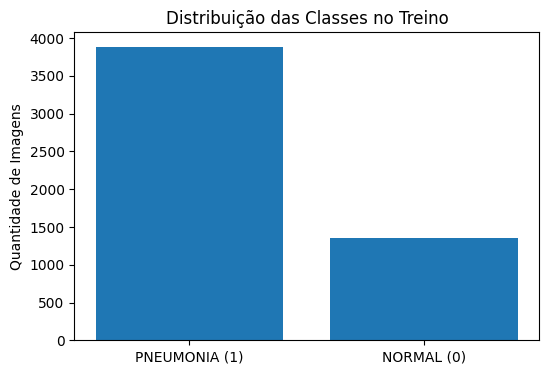

In [ ]:

# Contagem de imagens por classe a partir das pastas
n_pne = len(os.listdir(PNE_DIR))    # classe positiva (pneumonia)
n_norm = len(os.listdir(NOR_DIR))  # classe negativa (normal)
total = n_pne + n_norm

# Exibição das quantidades brutas
print("Pneumonia:", n_pne)
print("Normal:", n_norm)
print("Total:", total)

# Cálculo das proporções (útil para entender desbalanceamento)
p_pne = n_pne / total
p_norm = n_norm / total

print(f"Proporção Pneumonia: {p_pne:.3f}")
print(f"Proporção Normal: {p_norm:.3f}")

# Plot simples para visualizar rapidamente o desbalanceamento
plt.figure(figsize=(6,4))
plt.bar(["PNEUMONIA (1)", "NORMAL (0)"], [n_pne, n_norm])
plt.title("Distribuição das Classes no Treino")
plt.ylabel("Quantidade de Imagens")
plt.show()


## 3.3 Visualização de Amostras

Nesta etapa, visualizamos algumas imagens aleatórias de cada classe para:

- Identificar padrões visuais iniciais (ex.: opacidades, regiões esbranquiçadas)
- Entender a variabilidade das imagens (contraste, posição, ruído)
- Verificar se existe alguma anomalia (ex.: imagens corrompidas, cortes estranhos)

Essa inspeção também orienta decisões futuras sobre pré-processamento e data augmentation.


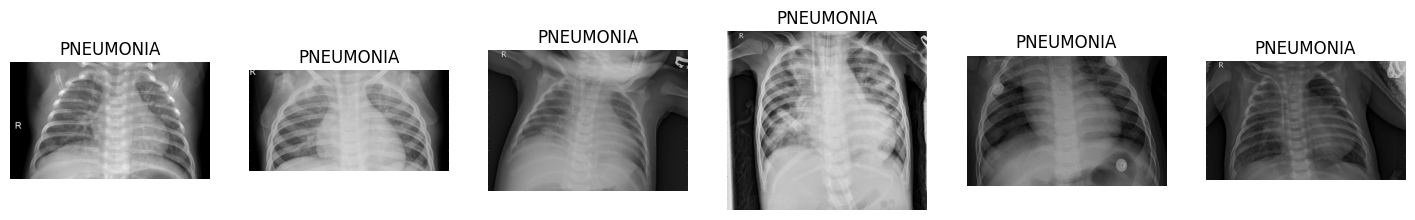

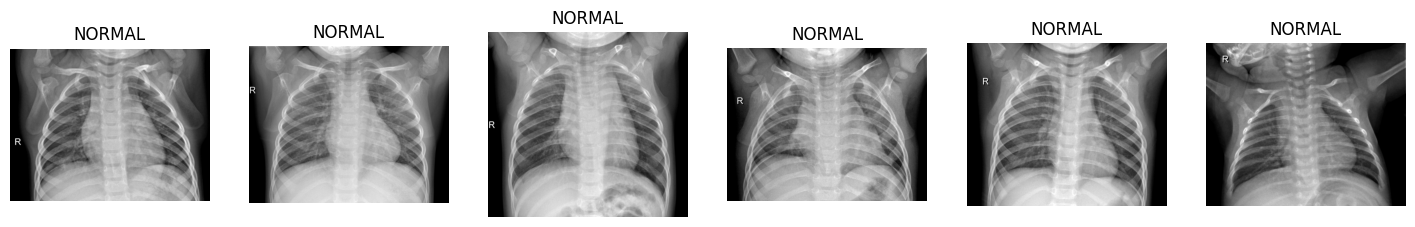

In [ ]:
def show_random_images(folder, title, n=6, seed=SEED):

    #Mostra 'n' imagens aleatórias de uma pasta.
    #- folder: caminho da pasta
    #- title: título exibido no plot
    #- n: quantidade de imagens
    #- seed: para reprodutibilidade da amostra

    random.seed(seed)
    files = os.listdir(folder)
    samples = random.sample(files, k=min(n, len(files)))  # evita erro se n > total

    # Cria uma figura com n colunas
    plt.figure(figsize=(3*n, 3))
    for i, fname in enumerate(samples):
        path = os.path.join(folder, fname)

        # Abre a imagem (convertendo para RGB para evitar problemas de modo)
        img = Image.open(path).convert("RGB")

        # Plot
        plt.subplot(1, len(samples), i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")

    plt.show()

# Mostra 6 imagens de pneumonia e 6 de normal
show_random_images(PNE_DIR, "PNEUMONIA", n=6)
show_random_images(NOR_DIR, "NORMAL", n=6)


### 3.3 Observações Iniciais (Inspeção Visual)

A inspeção visual de amostras aleatórias sugere diferenças consistentes entre as classes:

- **PNEUMONIA:** as imagens tendem a apresentar regiões mais **esbranquiçadas/opacas** no campo pulmonar, compatíveis com padrões de consolidação/infiltração.
- **NORMAL:** em geral observa-se maior presença de áreas **mais escuras** (maior “preto” associado ao ar nos pulmões), com melhor definição de estruturas internas.

Entretanto, foi possível observar que **algumas imagens normais podem aparecer levemente mais esbranquiçadas**, o que pode ocorrer por fatores de aquisição do exame (ex.: incidência/posição do raio-X, contraste, exposição). Esse comportamento é relevante pois pode gerar **falsos positivos**, que no contexto clínico tendem a ser menos graves do que falsos negativos (caso doente classificado como normal).

Além disso, a descrição do dataset indica que as imagens foram obtidas de **coortes retrospectivas de pacientes pediátricos (1 a 5 anos) do Guangzhou Women and Children’s Medical Center**. Isso é importante porque padrões anatômicos e a distribuição de contraste (proporção “preto/branco”) podem diferir significativamente de exames de adultos, afetando a generalização do modelo para outras populações. :contentReference[oaicite:1]{index=1}

Por fim, também notamos que em imagens normais costuma haver:
- **melhor visualização do contorno cardíaco**;
- **ossos mais brancos e nítidos**, o que pode servir como pista visual adicional para o modelo (mas também exige cuidado para evitar que o modelo aprenda “atalhos” incorretos).


## 3.4 Resolução e Proporção (Aspect Ratio)

Nesta etapa analisamos a resolução (largura x altura) e a proporção (W/H) das imagens do treino.

Motivações:

- Definir um tamanho padrão de entrada (`IMG_SIZE`) para modelos pré-treinados.
- Identificar variações de resolução que podem afetar o pré-processamento.
- Avaliar se o `Resize` para um tamanho fixo pode introduzir distorções relevantes.

Para tornar a análise rápida, usamos uma **amostra** de imagens ao invés de carregar todo o conjunto.


In [ ]:
# Configurações da amostragem
sample_size = 300
random.seed(SEED)

# Lista de caminhos das imagens (misturando as duas classes)
pne_files = [os.path.join(PNE_DIR, f) for f in os.listdir(PNE_DIR)]
nor_files = [os.path.join(NOR_DIR, f) for f in os.listdir(NOR_DIR)]
all_train_files = pne_files + nor_files

# Amostra aleatória para acelerar (sem precisar abrir todas as imagens)
sample_paths = random.sample(all_train_files, k=min(sample_size, len(all_train_files)))

# Coleta de dimensões
widths, heights, ratios = [], [], []

for path in sample_paths:
    # Abre imagem somente para ler tamanho (leve)
    with Image.open(path) as img:
        w, h = img.size
    widths.append(w)
    heights.append(h)
    ratios.append(w / h)

widths = np.array(widths)
heights = np.array(heights)
ratios = np.array(ratios)

# Estatísticas descritivas
print("Amostra analisada:", len(sample_paths))
print(f"Largura  - min/mediana/máx: {widths.min()} / {int(np.median(widths))} / {widths.max()}")
print(f"Altura   - min/mediana/máx: {heights.min()} / {int(np.median(heights))} / {heights.max()}")
print(f"Aspect   - min/mediana/máx: {ratios.min():.3f} / {np.median(ratios):.3f} / {ratios.max():.3f}")


Amostra analisada: 300
Largura  - min/mediana/máx: 448 / 1272 / 2916
Altura   - min/mediana/máx: 157 / 884 / 2583
Aspect   - min/mediana/máx: 0.938 / 1.416 / 2.930


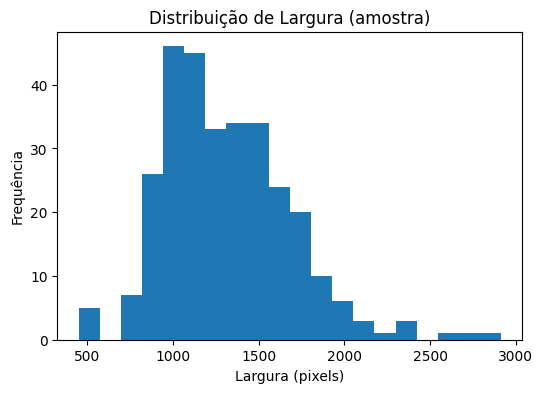

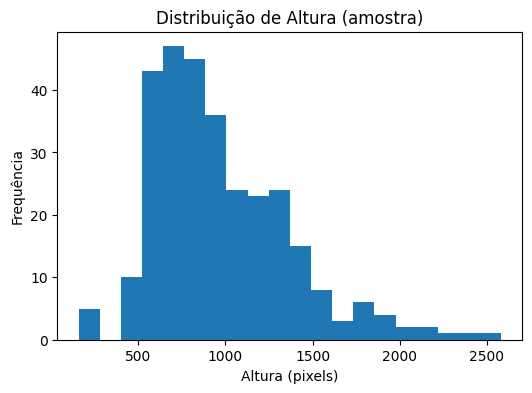

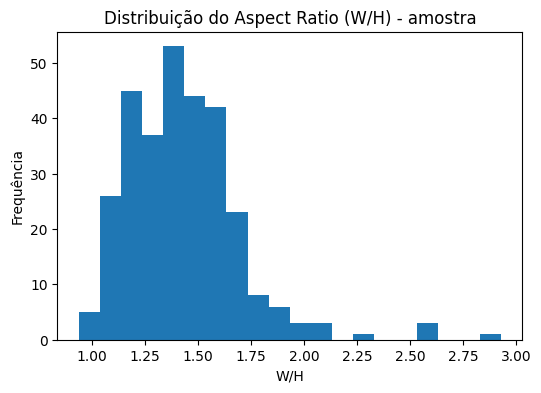

In [ ]:
# Histograma de larguras
plt.figure(figsize=(6,4))
plt.hist(widths, bins=20)
plt.title("Distribuição de Largura (amostra)")
plt.xlabel("Largura (pixels)")
plt.ylabel("Frequência")
plt.show()

# Histograma de alturas
plt.figure(figsize=(6,4))
plt.hist(heights, bins=20)
plt.title("Distribuição de Altura (amostra)")
plt.xlabel("Altura (pixels)")
plt.ylabel("Frequência")
plt.show()

# Histograma do aspect ratio (W/H)
plt.figure(figsize=(6,4))
plt.hist(ratios, bins=20)
plt.title("Distribuição do Aspect Ratio (W/H) - amostra")
plt.xlabel("W/H")
plt.ylabel("Frequência")
plt.show()


### Interpretação

Observamos variação relevante na resolução das imagens (largura e altura), o que exige padronização antes do treinamento.
A maioria das imagens apresenta aspect ratio entre ~1.25 e 1.75, com alguns outliers mais extremos (até ~2.7), indicando que muitas imagens são mais largas do que altas.

Para utilizar modelos pré-treinados, é necessário definir um tamanho de entrada fixo. Inicialmente, adotaremos `Resize` para um tamanho padrão (ex.: 224×224) como baseline por simplicidade e reprodutibilidade. Em etapas posteriores, poderemos avaliar estratégias que preservem melhor a proporção geométrica, como padding (letterbox), caso a distorção afete a performance.


# 4. Construção do Dataset e Estratégia de Validação

Nesta seção construímos os DataFrames de treino e teste de forma consistente com os arquivos oficiais da competição:

- `train.csv` contém a referência oficial (`id`, `label`) para treinamento.
- `test.csv` contém os `id`s esperados no arquivo de submissão.

Além disso:
- validamos se os arquivos existentes nas pastas correspondem aos `id`s dos CSVs;
- montamos o caminho completo de cada imagem (`path`);
- definimos uma estratégia de validação com **StratifiedKFold**, preservando o desbalanceamento de classes em cada fold.


## 4.1 Carregamento dos CSVs Oficiais

Os CSVs fornecidos pela competição são a fonte oficial de:

- `id`: identificador do arquivo (inclui extensão `.jpeg`)
- `label`: rótulo binário no conjunto de treino

Nesta etapa, carregamos os CSVs e inspecionamos seu formato.


In [ ]:
# 4.1 Leitura dos CSVs

train_csv = pd.read_csv(TRAIN_CSV)
test_csv  = pd.read_csv(TEST_CSV)

display(train_csv.head())
display(test_csv.head())

print("Colunas train.csv:", train_csv.columns.tolist())
print("Colunas test.csv:", test_csv.columns.tolist())
print("Shapes:", train_csv.shape, test_csv.shape)


,id,label
0,NORMAL-8648239-0004.jpeg,0
1,NORMAL-388586-0003.jpeg,0
2,NORMAL-7824011-0001.jpeg,0
3,NORMAL-8234246-0001.jpeg,0
4,NORMAL-5505017-0001.jpeg,0


,id
0,img_0001.jpeg
1,img_0002.jpeg
2,img_0003.jpeg
3,img_0004.jpeg
4,img_0005.jpeg


Colunas train.csv: ['id', 'label']
Colunas test.csv: ['id']
Shapes: (5232, 2) (624, 1)


## 4.2 Construção do DataFrame de Treino (`df_train`)

Construímos `df_train` a partir do `train.csv`, garantindo que:

- cada `id` tenha um arquivo correspondente na pasta de imagens;
- o `label` utilizado é o rótulo oficial fornecido pela competição.

Também criamos a coluna `path` com o caminho completo da imagem para uso no DataLoader.


In [ ]:
# 4.2 df_train: CSV -> path

# Conjunto de arquivos existentes nas pastas (ids com extensão)
files_pne = set(os.listdir(PNE_DIR))
files_nor = set(os.listdir(NOR_DIR))
files_all = files_pne | files_nor

# Checagem: todo id do train.csv precisa existir nas pastas
missing_train_files = set(train_csv["id"]) - files_all
print("Arquivos do train.csv que NÃO estão nas pastas:", len(missing_train_files))
assert len(missing_train_files) == 0, "Existem ids no train.csv sem arquivo correspondente nas pastas."

# Função para criar o path correto de cada id
def build_train_path(img_id: str) -> str:
    # Decide se o arquivo está em PNE_DIR ou NOR_DIR
    if img_id in files_pne:
        return os.path.join(PNE_DIR, img_id)
    elif img_id in files_nor:
        return os.path.join(NOR_DIR, img_id)
    else:
        # Isso não deveria acontecer por causa do assert acima
        return None

df_train = train_csv.copy()
df_train["path"] = df_train["id"].apply(build_train_path)

# Checagem final: nenhum path pode ficar nulo
assert df_train["path"].isna().sum() == 0, "Alguns paths ficaram nulos. Verifique as pastas."

# Embaralha para não ficar com blocos ordenados
df_train = df_train.sample(frac=1, random_state=SEED).reset_index(drop=True)

print("df_train shape:", df_train.shape)
df_train.head()


Arquivos do train.csv que NÃO estão nas pastas: 0
df_train shape: (5232, 3)


,id,label,path
0,NORMAL-9543520-0001.jpeg,0,/content/drive/MyDrive/Ligia_compviz/ligia-com...
1,NORMAL-8714707-0001.jpeg,0,/content/drive/MyDrive/Ligia_compviz/ligia-com...
2,VIRUS-2750119-0003.jpeg,1,/content/drive/MyDrive/Ligia_compviz/ligia-com...
3,BACTERIA-1157929-0001.jpeg,1,/content/drive/MyDrive/Ligia_compviz/ligia-com...
4,BACTERIA-6171093-0001.jpeg,1,/content/drive/MyDrive/Ligia_compviz/ligia-com...


## 4.3 Construção do DataFrame de Teste (`df_test`)

No conjunto de teste, os rótulos não são fornecidos. O objetivo é:

- associar cada `id` do `test.csv` ao respectivo arquivo na pasta `test_images`;
- garantir que os `ids` utilizados na submissão sigam exatamente o formato esperado (incluindo `.jpeg`).


In [ ]:
# 4.3 df_test: test.csv -> path

# Arquivos disponíveis na pasta de teste
test_files_in_dir = set(os.listdir(TEST_IMG_DIR))

# Checagem: todo id do test.csv precisa existir na pasta
missing_test_files = set(test_csv["id"]) - test_files_in_dir
print("Arquivos do test.csv que NÃO estão na pasta:", len(missing_test_files))
assert len(missing_test_files) == 0, "Existem ids no test.csv sem arquivo correspondente em test_images."

df_test = test_csv.copy()  # mantém o id oficial
df_test["path"] = df_test["id"].apply(lambda x: os.path.join(TEST_IMG_DIR, x))

print("df_test shape:", df_test.shape)
df_test.head()


Arquivos do test.csv que NÃO estão na pasta: 0
df_test shape: (624, 2)


,id,path
0,img_0001.jpeg,/content/drive/MyDrive/Ligia_compviz/ligia-com...
1,img_0002.jpeg,/content/drive/MyDrive/Ligia_compviz/ligia-com...
2,img_0003.jpeg,/content/drive/MyDrive/Ligia_compviz/ligia-com...
3,img_0004.jpeg,/content/drive/MyDrive/Ligia_compviz/ligia-com...
4,img_0005.jpeg,/content/drive/MyDrive/Ligia_compviz/ligia-com...


## 4.4 Validação com StratifiedKFold

Como o dataset é desbalanceado, utilizamos **StratifiedKFold** para que cada fold mantenha uma proporção de classes semelhante ao conjunto original.

Isso melhora a confiabilidade da validação e reduz variações artificiais entre folds.


In [ ]:
# 4.4 Criação dos folds

N_SPLITS = 5

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

df_train["fold"] = -1  # coluna para guardar o fold de cada amostra

for fold, (_, val_idx) in enumerate(skf.split(df_train["path"], df_train["label"])):
    df_train.loc[val_idx, "fold"] = fold

# Checagem: distribuição de classes por fold (deve ser semelhante)
for f in range(N_SPLITS):
    counts = df_train[df_train["fold"] == f]["label"].value_counts(normalize=True)
    print(f"Fold {f} proporções:\n{counts}\n")

df_train.head()


Fold 0 proporções:
label
1    0.74212
0    0.25788
Name: proportion, dtype: float64

Fold 1 proporções:
label
1    0.74212
0    0.25788
Name: proportion, dtype: float64

Fold 2 proporções:
label
1    0.741874
0    0.258126
Name: proportion, dtype: float64

Fold 3 proporções:
label
1    0.741874
0    0.258126
Name: proportion, dtype: float64

Fold 4 proporções:
label
1    0.74283
0    0.25717
Name: proportion, dtype: float64



,id,label,path,fold
0,NORMAL-9543520-0001.jpeg,0,/content/drive/MyDrive/Ligia_compviz/ligia-com...,1
1,NORMAL-8714707-0001.jpeg,0,/content/drive/MyDrive/Ligia_compviz/ligia-com...,3
2,VIRUS-2750119-0003.jpeg,1,/content/drive/MyDrive/Ligia_compviz/ligia-com...,3
3,BACTERIA-1157929-0001.jpeg,1,/content/drive/MyDrive/Ligia_compviz/ligia-com...,3
4,BACTERIA-6171093-0001.jpeg,1,/content/drive/MyDrive/Ligia_compviz/ligia-com...,3


# 5. Pré-processamento e DataLoaders

Nesta seção definimos como as imagens serão preparadas antes de entrarem no modelo.

Inclui:

- Definição do tamanho padrão da imagem (`IMG_SIZE`)
- Transformações para treino (com data augmentation controlado)
- Transformações para validação/teste (sem augmentation)
- Criação de um `Dataset` customizado e `DataLoader`

Como utilizaremos modelos pré-treinados, aplicamos normalização compatível com ImageNet.
Além disso, aplicamos augmentation apenas no treino para melhorar generalização,
mantendo validação/teste determinísticos.


## 5.1 Transformações (Transforms)

Como vimos no EDA, as imagens possuem resoluções e aspect ratios variados.
Para alimentar redes neurais, padronizamos o tamanho.

- **Treino:** inclui augmentations leves (ex.: rotação pequena e flip horizontal),
  visando robustez a variações de aquisição.
- **Validação/Teste:** apenas resize + normalização, para medir desempenho de forma estável.


In [ ]:
IMG_SIZE = 224  # baseline comum em modelos pré-treinados (ResNet/EfficientNet)

# Transformações do treino (com augmentation leve)
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),        # padroniza o tamanho
    transforms.RandomHorizontalFlip(p=0.5),          # variação leve (não altera anatomia verticalmente)
    transforms.RandomRotation(degrees=10),           # rotação pequena (simula variação de posicionamento)
    transforms.ToTensor(),                          # converte para tensor [0,1]
    transforms.Normalize([0.485, 0.456, 0.406],      # normalização ImageNet
                         [0.229, 0.224, 0.225]),
])

# Transformações para validação e teste (sem augmentation)
valid_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])


## 5.2 Dataset Customizado

Criamos um Dataset customizado para:

- Ler imagens a partir da coluna `path`
- Retornar `(imagem, label)` no treino/validação
- Retornar apenas `imagem` no teste

A conversão para `RGB` é utilizada para compatibilidade direta com modelos pré-treinados em ImageNet.


In [ ]:
class XRayDataset(Dataset):
    def __init__(self, df, transform=None, has_label=True):

        # df: DataFrame com colunas:
        # - path (obrigatório)
        # - label (se has_label=True)

        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.has_label = has_label

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Abre imagem e converte para RGB (compatível com modelos ImageNet)
        img = Image.open(row["path"]).convert("RGB")

        # Aplica transformações
        if self.transform:
            img = self.transform(img)

        # Se houver label (treino/validação), retorna (img, label)
        if self.has_label:
            y = torch.tensor(row["label"], dtype=torch.float32)
            return img, y

        # Caso teste, retorna apenas imagem
        return img


## 5.3 DataLoaders com Separação por Fold

Usaremos a coluna `fold` criada na Seção 4 para separar treino e validação.

Isso garante que:
- treino e validação são disjuntos
- a validação preserva a distribuição de classes (stratified)


In [ ]:
def make_loaders(df_train, fold=0, batch_size=32, num_workers=2):
    # Separa treino e validação
    df_tr = df_train[df_train["fold"] != fold].reset_index(drop=True)
    df_va = df_train[df_train["fold"] == fold].reset_index(drop=True)

    # Cria datasets
    ds_tr = XRayDataset(df_tr, transform=train_tfms, has_label=True)
    ds_va = XRayDataset(df_va, transform=valid_tfms, has_label=True)

    # DataLoaders
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,
                       num_workers=num_workers, pin_memory=True)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False,
                       num_workers=num_workers, pin_memory=True)

    return dl_tr, dl_va

# Exemplo: loaders do fold 0
train_loader, valid_loader = make_loaders(df_train, fold=0, batch_size=32)

# Test loader
test_dataset = XRayDataset(df_test, transform=valid_tfms, has_label=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader))
print("Valid batches:", len(valid_loader))
print("Test batches :", len(test_loader))


Train batches: 131
Valid batches: 33
Test batches : 20


# 6. Modelagem e Treinamento

Nesta seção definimos e treinamos um modelo de Deep Learning para classificar
imagens de raio-X torácico em:

- 0 → Normal
- 1 → Pneumonia

Como estratégia principal, utilizamos **Transfer Learning** com uma rede pré-treinada em ImageNet.
Isso é útil pois o dataset não é gigantesco e o modelo pré-treinado já possui filtros visuais
úteis (bordas, texturas, padrões), acelerando a convergência.

A saída do modelo será um **score contínuo** (logit), que será convertido em probabilidade via sigmoide.
A métrica de validação será a **ROC-AUC**, compatível com a avaliação da competição.


## 6.1 Arquitetura do Modelo

Usaremos a EfficientNet-B0 pré-treinada. Substituímos a camada final para produzir 1 logit:

- logit → `sigmoid(logit)` = probabilidade de pneumonia

Essa configuração é adequada para classificação binária com `BCEWithLogitsLoss`,
que aplica internamente a sigmoide de forma numericamente estável.


In [ ]:
import torchvision.models as models
import torch.nn as nn

def build_model():
    # Carrega EfficientNet-B0 pré-treinada
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

    # Troca a camada final para saída binária (1 logit)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 1)

    return model


## 6.2 Função de Perda e Otimizador

Como o dataset é desbalanceado (maioria pneumonia), utilizamos `pos_weight` na loss
para penalizar mais erros na classe positiva (pneumonia).

A loss escolhida é:

- `BCEWithLogitsLoss(pos_weight=...)`

Otimizador:
- `AdamW` (boa estabilidade e regularização via weight decay)

Scheduler:
- `CosineAnnealingLR` (reduz a taxa de aprendizado suavemente ao longo das épocas)


In [ ]:
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

def get_criterion(df):
    # Calcula pos_weight = (negativos / positivos)
    pos = (df["label"] == 1).sum()
    neg = (df["label"] == 0).sum()
    pos_weight = torch.tensor([neg / pos], device=device, dtype=torch.float32)

    print("pos_weight:", pos_weight.item())
    return nn.BCEWithLogitsLoss(pos_weight=pos_weight)

criterion = get_criterion(df_train)


pos_weight: 0.34741178154945374


## 6.3 Treino e Validação

Durante o treino, o modelo recebe imagens e retorna logits.
Na validação, convertemos logits em probabilidades usando `sigmoid` e calculamos ROC-AUC.

Importante:
- ROC-AUC usa **scores contínuos** (probabilidades), não rótulos 0/1.


In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np

def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device).unsqueeze(1)  # shape (B,1)

        optimizer.zero_grad()

        logits = model(x)             # saída: logit
        loss = criterion(logits, y)   # BCEWithLogitsLoss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)

    return running_loss / len(loader.dataset)

@torch.no_grad()
def valid_one_epoch(model, loader):
    model.eval()
    probs = []
    ys = []

    for x, y in loader:
        x = x.to(device)

        logits = model(x)
        p = torch.sigmoid(logits).cpu().numpy().ravel()  # probabilidade de pneumonia

        probs.append(p)
        ys.append(y.numpy().ravel())

    probs = np.concatenate(probs)
    ys = np.concatenate(ys)

    auc = roc_auc_score(ys, probs)
    return auc

## 6.4 Treinamento Inicial (Fold único)

Primeiro treinamos em um único fold para validar o pipeline completo:

- DataLoader
- Modelo
- Loss
- AUC

Após confirmar que está funcionando, expandiremos para 5 folds e ensemble.


In [ ]:
# Configuração inicial (Fold único) + salvar best_state

FOLD = 0
EPOCHS = 3
LR = 3e-4
BATCH_SIZE = 32

train_loader, valid_loader = make_loaders(df_train, fold=FOLD, batch_size=BATCH_SIZE)

model = build_model().to(device)
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

best_auc = -1
best_state = None  # garante que existe mesmo se algo der errado

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_auc = valid_one_epoch(model, valid_loader)
    scheduler.step()

    print(f"Epoch {epoch}/{EPOCHS} | loss={train_loss:.4f} | val_auc={val_auc:.4f}")

    # Salva o melhor checkpoint (na CPU para economizar VRAM e facilitar reutilização)
    if val_auc > best_auc:
        best_auc = val_auc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

print("Best AUC:", best_auc)

# Recarrega o melhor estado no modelo (para garantir que o 'model' final é o melhor)
model.load_state_dict(best_state)
model = model.to(device)
print("✅ Best model carregado no objeto 'model'.")

# (Opcional) Salvar em arquivo para usar depois (Seção 7 / Grad-CAM) sem retreinar
torch.save(best_state, f"best_model_fold{FOLD}.pth")
print(f"✅ Checkpoint salvo em: best_model_fold{FOLD}.pth")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 80.3MB/s]


Epoch 1/3 | loss=0.0864 | val_auc=0.9928
Epoch 2/3 | loss=0.0388 | val_auc=0.9980
Epoch 3/3 | loss=0.0228 | val_auc=0.9987
Best AUC: 0.9986843986843987
✅ Best model carregado no objeto 'model'.
✅ Checkpoint salvo em: best_model_fold0.pth


## 6.5 Treinamento com Validação Cruzada (5-Fold) e Ensemble

Para aumentar robustez e reduzir variância do modelo, treinamos 1 modelo por fold.

Para o conjunto de teste, geramos probabilidades com cada modelo e tiramos a média (ensemble),
o que normalmente melhora a performance em competições Kaggle.

Nesta etapa registramos:
- AUC de cada fold
- AUC médio
- Probabilidades finais no teste (média dos folds)


In [ ]:
@torch.no_grad()
def predict_proba(model, loader):
    #Retorna probabilidades (sigmoid) para todos os itens do loader, na ordem.
    model.eval()
    all_probs = []
    for batch in loader:
        # batch pode ser (x,y) ou só x (teste)
        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            x, _ = batch
        else:
            x = batch

        x = x.to(device)
        logits = model(x)
        probs = torch.sigmoid(logits).detach().cpu().numpy().ravel()
        all_probs.append(probs)

    return np.concatenate(all_probs)


In [ ]:
N_SPLITS = 5
EPOCHS = 3
LR = 3e-4
BATCH_SIZE = 32
NUM_WORKERS = 2

fold_aucs = []
test_pred_folds = []

best_states = []        # guarda best_state em memória (opcional, mas útil)
val_probs_folds = []    # (opcional) probs de validação por fold
val_true_folds = []     # (opcional) labels verdadeiros por fold

# dataset/loader de teste
test_dataset = XRayDataset(df_test, transform=valid_tfms, has_label=False)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda")
)

for fold in range(N_SPLITS):
    print(f"\n==================== FOLD {fold} ====================")

    # Loaders do fold atual
    train_loader, valid_loader = make_loaders(
        df_train, fold=fold, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
    )

    # Modelo + otimizador + scheduler
    model = build_model().to(device)
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

    best_auc = -1
    best_state = None

    for epoch in range(1, EPOCHS + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer)
        val_auc = valid_one_epoch(model, valid_loader)
        scheduler.step()

        print(f"Epoch {epoch}/{EPOCHS} | loss={train_loss:.4f} | val_auc={val_auc:.4f}")

        if val_auc > best_auc:
            best_auc = val_auc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    # Guarda AUC do fold
    fold_aucs.append(best_auc)
    print(f"Best AUC (fold {fold}): {best_auc:.6f}")

    # Salva best_state em memória (opcional)
    best_states.append(best_state)

    # Salva best_state em arquivo (recomendado)
    ckpt_path = f"best_model_fold{fold}.pth"
    torch.save(best_state, ckpt_path)
    print(f"✅ Checkpoint salvo em: {ckpt_path}")

    # Carrega melhor estado e prediz no teste
    model.load_state_dict(best_state)
    model = model.to(device)

    test_probs = predict_proba(model, test_loader)
    test_pred_folds.append(test_probs)

    # (Opcional) salvar probs da validação (para Seção 7 sem retrain)
    df_va = df_train[df_train["fold"] == fold].reset_index(drop=True)
    val_probs = predict_proba(model, valid_loader)  # valid_loader já está no fold certo e sem shuffle
    val_probs_folds.append(val_probs)
    val_true_folds.append(df_va["label"].values)

# Resultado final
print("\nAUCs por fold:", [round(float(a), 6) for a in fold_aucs])
print("AUC médio:", float(np.mean(fold_aucs)))

# Ensemble (média das probabilidades dos folds)
test_pred_mean = np.mean(np.stack(test_pred_folds, axis=0), axis=0)
print("test_pred_mean shape:", test_pred_mean.shape)



==================== FOLD 0 ====================
Epoch 1/3 | loss=0.0778 | val_auc=0.9967
Epoch 2/3 | loss=0.0371 | val_auc=0.9984
Epoch 3/3 | loss=0.0208 | val_auc=0.9989
Best AUC (fold 0): 0.998913
✅ Checkpoint salvo em: best_model_fold0.pth

==================== FOLD 1 ====================
Epoch 1/3 | loss=0.0844 | val_auc=0.9961
Epoch 2/3 | loss=0.0332 | val_auc=0.9983
Epoch 3/3 | loss=0.0249 | val_auc=0.9986
Best AUC (fold 1): 0.998637
✅ Checkpoint salvo em: best_model_fold1.pth

==================== FOLD 2 ====================
Epoch 1/3 | loss=0.0801 | val_auc=0.9988
Epoch 2/3 | loss=0.0349 | val_auc=0.9984
Epoch 3/3 | loss=0.0197 | val_auc=0.9992
Best AUC (fold 2): 0.999165
✅ Checkpoint salvo em: best_model_fold2.pth

==================== FOLD 3 ====================
Epoch 1/3 | loss=0.0847 | val_auc=0.9972
Epoch 2/3 | loss=0.0357 | val_auc=0.9988
Epoch 3/3 | loss=0.0230 | val_auc=0.9993
Best AUC (fold 3): 0.999322
✅ Checkpoint salvo em: best_model_fold3.pth

===================

# 7. Avaliação e Análise de Erros (Fold 0)

A métrica principal da competição é ROC-AUC, que mede a capacidade do modelo de ranquear corretamente
exemplos positivos acima de negativos, sem exigir um limiar (threshold) fixo.

Entretanto, para interpretar o comportamento do modelo em um cenário de decisão binária
(e para o relatório), também avaliamos métricas dependentes de threshold:

- Matriz de confusão (TN, FP, FN, TP)
- Precision, Recall, F1-score
- Análise qualitativa de erros (FP e FN)

**Observação importante:** escolher um threshold é uma decisão de "métrica de negócio".
Em aplicações médicas, geralmente buscamos **alto recall** (reduzir falsos negativos),
mesmo que isso aumente falsos positivos.


## 7.1 Probabilidades na validação (Fold 0)

Nesta etapa:
1. Selecionamos o conjunto de validação do fold 0 (definido pelo StratifiedKFold).
2. Carregamos o checkpoint salvo (`best_model_fold0.pth`).
3. Geramos probabilidades para cada imagem do fold 0:

- O modelo retorna **logits** (valores reais).
- Aplicamos `sigmoid(logit)` para obter **probabilidade** de pneumonia.

Essas probabilidades serão usadas para ROC-AUC, matriz de confusão e análise de erros.


In [ ]:
# 7.1 Gerar probabilidades na validação (Fold 0)

FOLD_ANALYSIS = 0
BATCH_SIZE = 32
NUM_WORKERS = 2

# 1) Filtra os dados do fold 0 (validação)
df_va = df_train[df_train["fold"] == FOLD_ANALYSIS].reset_index(drop=True)

# 2) DataLoader da validação (sem shuffle para manter a ordem)
val_dataset = XRayDataset(df_va, transform=valid_tfms, has_label=True)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda")
)

# 3) Carrega checkpoint salvo do melhor modelo (fold 0)
state = torch.load("best_model_fold0.pth", map_location="cpu")

model = build_model().to(device)
model.load_state_dict(state)
model.eval()

# 4) Gera probabilidades p(y=1) usando sigmoid(logits)
val_probs = predict_proba(model, val_loader)  # shape (N,)
val_true  = df_va["label"].values             # shape (N,)

print("val_probs shape:", val_probs.shape)
print("ROC-AUC (fold 0):", roc_auc_score(val_true, val_probs))


val_probs shape: (1047,)
ROC-AUC (fold 0): 0.998913198913199


## 7.2 Métricas com threshold (0.5)

Como baseline, usamos threshold = 0.5:

- Se `p >= 0.5`, o modelo prediz pneumonia (classe 1).
- Caso contrário, prediz normal (classe 0).

A matriz de confusão segue o padrão:

[[TN, FP],
 [FN, TP]]

Onde:
- **FN** (falso negativo) é o caso mais crítico: pneumonia predita como normal.
- **FP** (falso positivo) pode gerar alarme indevido, mas é menos crítico em triagem.


In [ ]:
# 7.2 Matriz de confusão + relatório (threshold=0.5)

from sklearn.metrics import confusion_matrix, classification_report

thr = 0.5

# Converte probabilidade em predição binária
val_pred = (val_probs >= thr).astype(int)

# Matriz de confusão
cm = confusion_matrix(val_true, val_pred)
print("Confusion Matrix [[TN, FP],[FN, TP]]:\n", cm)

# Relatório completo: precision/recall/f1 por classe
print("\nClassification Report:\n")
print(classification_report(val_true, val_pred, digits=4))


Confusion Matrix [[TN, FP],[FN, TP]]:
 [[267   3]
 [ 20 757]]

Classification Report:

              precision    recall  f1-score   support

           0     0.9303    0.9889    0.9587       270
           1     0.9961    0.9743    0.9850       777

    accuracy                         0.9780      1047
   macro avg     0.9632    0.9816    0.9719      1047
weighted avg     0.9791    0.9780    0.9782      1047



## 7.3 Ajuste de threshold focando recall (métrica de negócio)

Como ROC-AUC é independente de threshold, a escolha de limiar é uma decisão do sistema.

Aqui testamos vários thresholds e escolhemos aquele que maximiza **recall** na validação.
Isso tende a reduzir FN (mais segurança), porém aumenta FP.


In [ ]:
# 7.3 Buscar threshold que maximize recall

thresholds = np.linspace(0.05, 0.95, 19)

best_thr = 0.5
best_recall = -1
best_tuple = None  # (tn, fp, fn, tp)

for t in thresholds:
    pred = (val_probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(val_true, pred).ravel()

    # Recall = TP / (TP + FN)
    recall = tp / (tp + fn + 1e-9)

    if recall > best_recall:
        best_recall = recall
        best_thr = t
        best_tuple = (tn, fp, fn, tp)

tn, fp, fn, tp = best_tuple
print("Melhor threshold (max recall):", best_thr)
print(f"TN={tn} FP={fp} FN={fn} TP={tp}")
print("Recall nesse threshold:", best_recall)


Melhor threshold (max recall): 0.05
TN=259 FP=11 FN=7 TP=770
Recall nesse threshold: 0.9909909909897155


## 7.4 Inspeção visual de erros (FP e FN)

Para interpretar os erros, exibimos imagens classificadas incorretamente:

- **Falsos Positivos (FP):** normal predito como pneumonia
- **Falsos Negativos (FN):** pneumonia predito como normal (mais crítico)

Nos gráficos, mostramos `p=...` acima de cada imagem:

- `p` é a probabilidade prevista de pneumonia (`target`).
- Ex.: `p=0.62` significa que o modelo estimou 62% de chance de pneumonia.

A inspeção visual ajuda a entender:
- padrões de erro associados a contraste/exposição do raio X
- casos ambíguos e “difíceis”
- possíveis atalhos (spurious correlations) que o modelo pode estar usando


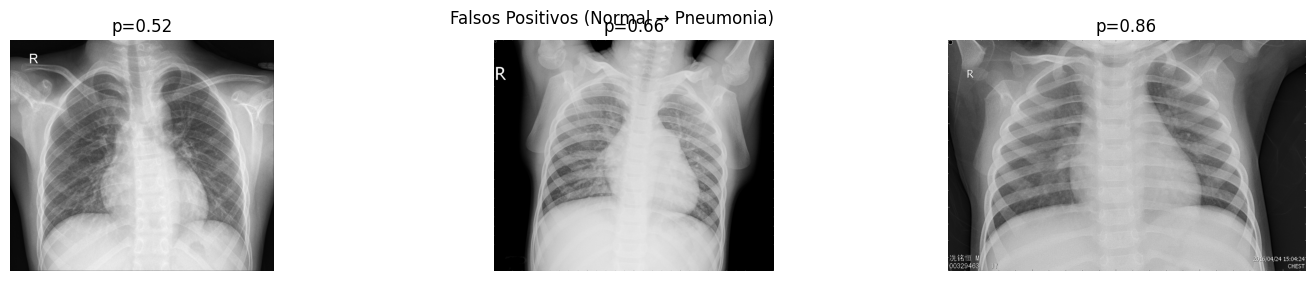

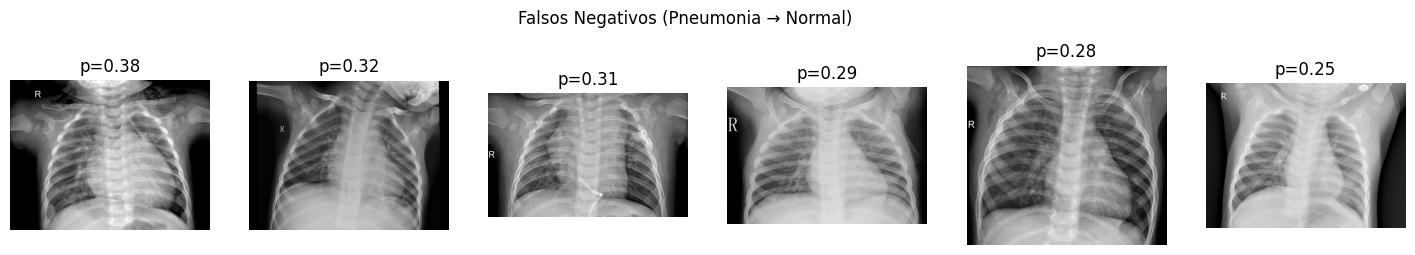

In [ ]:
# 7.4 Mostrar exemplos de FP/FN para análise de erro

def show_examples(df_va, y_true, y_prob, kind="FN", thr=0.5, n=6):

    #Exibe exemplos de erros com a probabilidade prevista p(y=1) no título.

    #kind="FN": y=1 e pred=0
    #kind="FP": y=0 e pred=1

    y_pred = (y_prob >= thr).astype(int)

    if kind == "FN":
        idx = np.where((y_true == 1) & (y_pred == 0))[0]
        title = "Falsos Negativos (Pneumonia → Normal)"
    else:
        idx = np.where((y_true == 0) & (y_pred == 1))[0]
        title = "Falsos Positivos (Normal → Pneumonia)"

    if len(idx) == 0:
        print(f"Nenhum exemplo de {kind} encontrado nesse threshold.")
        return

    # Seleciona os exemplos mais próximos do threshold (casos mais ambíguos)
    idx = sorted(idx, key=lambda i: abs(y_prob[i] - thr))[:n]

    plt.figure(figsize=(3*n, 3))
    for j, k in enumerate(idx):
        path = df_va.loc[k, "path"]
        img = Image.open(path).convert("RGB")

        plt.subplot(1, len(idx), j+1)
        plt.imshow(img)
        plt.title(f"p={y_prob[k]:.2f}")
        plt.axis("off")

    plt.suptitle(title)
    plt.show()

# Use thr=0.5 para a análise padrão
show_examples(df_va, val_true, val_probs, kind="FP", thr=0.5, n=6)
show_examples(df_va, val_true, val_probs, kind="FN", thr=0.5, n=6)


# 8. Interpretabilidade (XAI) com Grad-CAM

Para entender melhor como o modelo toma decisões, aplicamos Grad-CAM (Gradient-weighted Class Activation Mapping).

O Grad-CAM produz um mapa de calor que indica as regiões da imagem que mais contribuíram para a predição.
Isso é útil para:

- validar se o modelo está focando em regiões clinicamente plausíveis (ex.: áreas pulmonares);
- investigar erros (FP e FN) e possíveis "atalhos" (artefatos, bordas, textos, contraste);
- enriquecer o relatório com interpretabilidade, conectando métricas com explicações visuais.

Nesta seção:
- carregamos o melhor modelo do fold 0 (checkpoint salvo);
- selecionamos exemplos (TP, FP, FN) do fold 0;
- geramos mapas Grad-CAM e sobrepomos na imagem original.


## 8.1 Carregar modelo (Fold 0)

Usaremos o mesmo checkpoint utilizado na Seção 7 (`best_model_fold0.pth`) para garantir consistência:
as explicações (Grad-CAM) refletem exatamente o modelo avaliado.


In [ ]:
# Carrega o checkpoint do fold 0
state = torch.load("best_model_fold0.pth", map_location="cpu")

model = build_model().to(device)
model.load_state_dict(state)
model.eval();

print("✅ Modelo do fold 0 carregado para Grad-CAM.")


✅ Modelo do fold 0 carregado para Grad-CAM.


## 8.2 Implementação do Grad-CAM

O Grad-CAM usa:
- as ativações de uma camada convolucional (feature maps)
- os gradientes da saída (classe positiva) em relação a essas ativações

Em seguida, calcula um mapa de calor 2D (H×W) que indica a contribuição de cada região.

Escolhemos como camada alvo a última camada convolucional da EfficientNet (último bloco em `model.features`),
pois ela costuma capturar padrões de alto nível relevantes para a decisão.


In [ ]:
class GradCAM:

    # Implementação simples de Grad-CAM para um modelo PyTorch.
    # Funciona bem para arquiteturas conv (como EfficientNet/ResNet).

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None

        # Hook: captura ativações no forward
        def forward_hook(module, inp, out):
            self.activations = out.detach()

        # Hook: captura gradientes no backward
        def backward_hook(module, grad_in, grad_out):
            # grad_out é uma tupla; grad_out[0] é o gradiente das ativações
            self.gradients = grad_out[0].detach()

        self.fwd_handle = self.target_layer.register_forward_hook(forward_hook)
        self.bwd_handle = self.target_layer.register_full_backward_hook(backward_hook)

    def remove_hooks(self):
        self.fwd_handle.remove()
        self.bwd_handle.remove()

    def __call__(self, x):

        # x: tensor (1, C, H, W) já transformado/normalizado.
        # Retorna:
        # - cam: heatmap 2D normalizado [0,1] (H, W)
        # - prob: probabilidade prevista p(y=1)

        self.model.zero_grad()

        # Forward: logits
        logits = self.model(x)                  # shape (1,1)
        prob = torch.sigmoid(logits).item()

        # Backward: gradiente do logit da classe positiva (pneumonia)
        logits.backward(torch.ones_like(logits))

        # Ativações e gradientes: (1, C, h, w)
        A = self.activations
        dA = self.gradients

        # Pesos = média global dos gradientes por canal: (C,)
        weights = dA.mean(dim=(2, 3), keepdim=True)  # (1, C, 1, 1)

        # Combinação ponderada dos mapas: (1, 1, h, w)
        cam = (weights * A).sum(dim=1, keepdim=True)

        # ReLU (mantém apenas contribuições positivas)
        cam = torch.relu(cam)

        # Normaliza para [0,1]
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-9)

        return cam, prob


## 8.3 Visualização

Para visualizar o Grad-CAM:
- carregamos a imagem original (para exibição)
- aplicamos as transformações de validação (`valid_tfms`) para alimentar o modelo
- geramos o mapa Grad-CAM em baixa resolução e fazemos resize para o tamanho da imagem exibida
- sobrepomos o heatmap na imagem original


In [ ]:
import cv2

def load_image_rgb(path):
    # Carrega imagem como RGB (PIL).
    return Image.open(path).convert("RGB")

def tensor_from_path(path):
    # Aplica valid_tfms e retorna tensor (1,C,H,W).
    img = load_image_rgb(path)
    x = valid_tfms(img).unsqueeze(0).to(device)
    return x

def overlay_heatmap_on_image(img_pil, cam, alpha=0.4):

    # Sobrepõe o heatmap (cam) em uma imagem PIL.
    # cam: array 2D em [0,1]

    img = np.array(img_pil)  # (H,W,3) RGB
    H, W = img.shape[:2]

    # Redimensiona CAM para o tamanho da imagem
    cam_resized = cv2.resize(cam, (W, H))

    # Converte cam em heatmap colorido (colormap)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Combina imagem + heatmap
    overlay = (1 - alpha) * img + alpha * heatmap
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)

    return overlay

def show_gradcam(path, cam, prob, title=""):
    # Exibe imagem original e imagem com overlay do Grad-CAM.
    img = load_image_rgb(path)
    overlay = overlay_heatmap_on_image(img, cam, alpha=0.4)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"{title}\n p(pneumonia)={prob:.3f}")
    plt.axis("off")
    plt.show()


## 8.4 Seleção de exemplos para análise (TP / FP / FN)

Usamos as probabilidades da validação (Seção 7) para selecionar exemplos representativos:
- **TP**: pneumonia correta com alta confiança
- **FP**: normal predito como pneumonia (erro)
- **FN**: pneumonia predito como normal (erro mais crítico)

Isso facilita escolher casos informativos sem seleção manual.


In [ ]:
# 8.4 Seleciona índices de TP/FP/FN com threshold 0.5

thr = 0.5
val_pred = (val_probs >= thr).astype(int)

# índices por tipo
tp_idx = np.where((val_true == 1) & (val_pred == 1))[0]
fp_idx = np.where((val_true == 0) & (val_pred == 1))[0]
fn_idx = np.where((val_true == 1) & (val_pred == 0))[0]

print("TP:", len(tp_idx), "FP:", len(fp_idx), "FN:", len(fn_idx))

# Escolhas "informativas":
# - TP mais confiante: maior prob
tp_best = tp_idx[np.argmax(val_probs[tp_idx])] if len(tp_idx) else None

# - FP mais confiante: maior prob (modelo muito certo e mesmo assim errou)
fp_best = fp_idx[np.argmax(val_probs[fp_idx])] if len(fp_idx) else None

# - FN mais "perigoso": menor prob (modelo muito certo que é normal, mas era pneumonia)
fn_best = fn_idx[np.argmin(val_probs[fn_idx])] if len(fn_idx) else None

tp_best, fp_best, fn_best


TP: 757 FP: 3 FN: 20


(np.int64(974), np.int64(591), np.int64(454))

## 8.5 Grad-CAM nos exemplos selecionados

Geramos o Grad-CAM para cada caso e verificamos se as regiões destacadas fazem sentido.

Idealmente:
- casos de pneumonia: o modelo deve destacar regiões pulmonares com opacidades/infiltrados;
- casos normais: o foco não deveria estar em bordas, marcas ou regiões fora do tórax.

Em erros (FP/FN), analisamos se o modelo foi "enganado" por contraste, exposição ou artefatos.


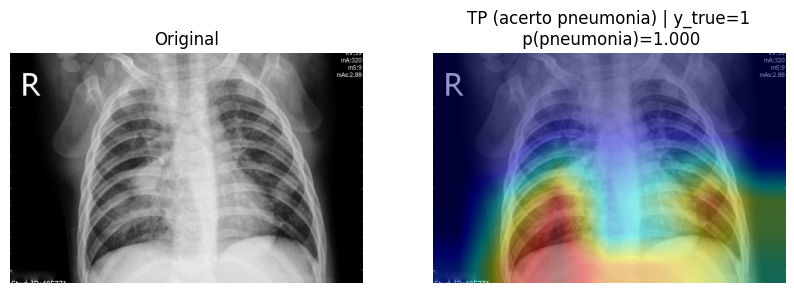

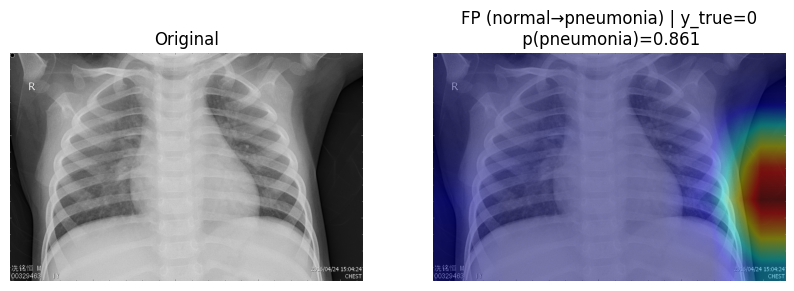

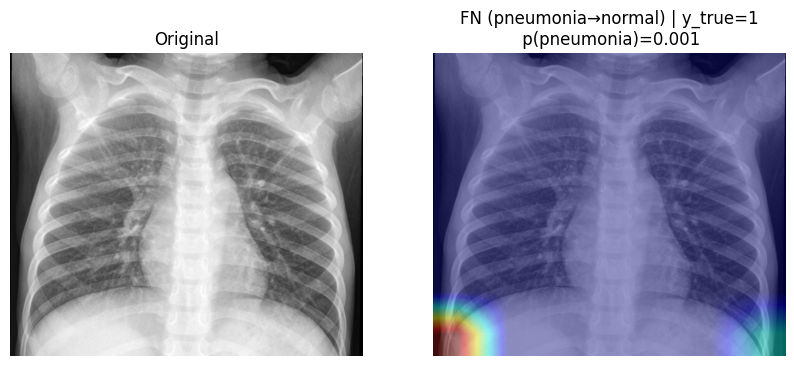

In [ ]:
# 8.5 Executar Grad-CAM

# camada alvo: último bloco convolucional da EfficientNet
target_layer = model.features[-1]

gradcam = GradCAM(model, target_layer)

def run_one(idx, label_name):
    if idx is None:
        print(f"Sem exemplo disponível para {label_name}.")
        return
    path = df_va.loc[idx, "path"]
    x = tensor_from_path(path)

    # Ativa gradiente (necessário para Grad-CAM)
    model.zero_grad()
    cam, prob = gradcam(x)

    # título: tipo + classe verdadeira
    y_true = int(df_va.loc[idx, "label"])
    title = f"{label_name} | y_true={y_true}"
    show_gradcam(path, cam, prob, title=title)

run_one(tp_best, "TP (acerto pneumonia)")
run_one(fp_best, "FP (normal→pneumonia)")
run_one(fn_best, "FN (pneumonia→normal)")


## 8.6 Interpretação dos mapas Grad-CAM (TP / FP / FN)

A análise por Grad-CAM permite verificar se o modelo toma decisões baseadas em regiões
anatomicamente plausíveis (ex.: campos pulmonares) ou se utiliza "atalhos" (artefatos e bordas).

### Caso TP (acerto – pneumonia)
No exemplo verdadeiro positivo (TP), o mapa Grad-CAM se concentrou predominantemente nos pulmões.
Esse padrão é consistente com a tarefa, já que alterações compatíveis com pneumonia em radiografias
tendem a se manifestar como opacidades/infiltrados nos campos pulmonares.  
**Interpretação:** o modelo utiliza evidências visuais relevantes para a decisão, indicando boa plausibilidade clínica.

### Caso FP (erro – normal → pneumonia)
No falso positivo (FP), observou-se ativação forte na borda direita da imagem, em uma região escura
fora da área de interesse (fora do tórax).  
**Interpretação:** o modelo possivelmente foi influenciado por um artefato/estrutura de borda,
em vez de padrões internos do parênquima pulmonar. Esse comportamento é típico quando o modelo aprende
pistas não relacionadas à patologia (ex.: moldura do exame, contraste, ruído, cortes da imagem).

### Caso FN (erro mais crítico – pneumonia → normal)
No falso negativo (FN), o Grad-CAM focou em uma região periférica próxima a estruturas ósseas (área mais branca),
em vez de destacar de forma predominante os campos pulmonares.  
**Interpretação:** o modelo pode ter supervalorizado padrões de alto contraste (ossos/exposição) e subestimado sinais
pulmonares mais sutis, resultando na não detecção do caso positivo. Em um cenário clínico, esse tipo de erro é mais grave,
pois representa pneumonia não sinalizada pelo sistema.

### Implicações e possíveis melhorias
Os casos FP/FN sugerem que, apesar do alto desempenho global, o modelo pode ocasionalmente se apoiar em regiões
fora do pulmão. Estratégias que podem mitigar esse efeito incluem:
- pré-processamento para reduzir influência de bordas (ex.: crop central ou remoção de margens);
- augmentations mais robustas (variação de contraste/brightness) para reduzir dependência de exposição;
- (opcional) uso de segmentação/ROI dos pulmões para forçar o foco na área de interesse.


In [ ]:
os.makedirs("gradcam_outputs", exist_ok=True)

def save_gradcam_figure(path, cam, prob, title, out_name):
    img = load_image_rgb(path)
    overlay = overlay_heatmap_on_image(img, cam, alpha=0.4)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"{title}\n p(pneumonia)={prob:.3f}")
    plt.axis("off")

    out_path = os.path.join("gradcam_outputs", out_name)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()
    print("Salvo em:", out_path)


# 9. Geração do Arquivo de Submissão

Nesta seção geramos o arquivo `submission.csv` no formato exigido pela competição.

A predição final do conjunto de teste utiliza **ensemble dos 5 folds**, calculando a média das probabilidades:

- `id`: identificador do arquivo (exatamente como em `test.csv`)
- `target`: probabilidade prevista para pneumonia (classe positiva)

Ao final, salvamos `submission.csv` no diretório de trabalho para envio no Kaggle.


## 9.1 Construção do arquivo `submission.csv` (com sanity checks)

Antes de salvar, fazemos verificações rápidas para evitar erros comuns:

- O número de linhas deve ser igual ao número de amostras no teste.
- Os `id`s não devem ter duplicatas.
- Os valores de `target` devem estar no intervalo [0, 1].


In [ ]:
# 9.1 Gerar submission.csv e salvar também no Drive

# Garante que temos predições para todo o teste
assert "test_pred_mean" in globals(), "test_pred_mean não encontrado. Rode a etapa de ensemble (Seção 6.5)."
assert "df_test" in globals(), "df_test não encontrado. Rode a Seção 4.3."
assert len(test_pred_mean) == len(df_test), "Quantidade de predições diferente do tamanho do df_test."

submission = pd.DataFrame({
    "id": df_test["id"],                      # ids oficiais do test.csv
    "target": test_pred_mean.astype(float)    # probabilidades (ensemble)
})

# Sanity checks
assert submission["id"].nunique() == len(submission), "IDs duplicados na submissão."
assert submission["target"].between(0, 1).all(), "Existem valores de target fora de [0, 1]."

# 1) Salva no diretório atual do runtime (Colab: /content)
local_path = os.path.abspath("submission.csv")
submission.to_csv(local_path, index=False)

# 2) Salva também no Drive (persistente)
assert "PROJECT_DIR" in globals(), "PROJECT_DIR não definido. Defina-o na Seção 0.5 (Drive)."
drive_path = os.path.join(PROJECT_DIR, "submission.csv")
submission.to_csv(drive_path, index=False)

print("✅ submission.csv salvo com sucesso!")
print("Local:", local_path)
print("Drive:", drive_path)

display(submission.head())
print("Shape:", submission.shape)
print("Target min/mean/max:",
      submission["target"].min(),
      submission["target"].mean(),
      submission["target"].max())


✅ submission.csv salvo com sucesso!
Local: /content/submission.csv
Drive: /content/drive/MyDrive/Ligia_compviz/submission.csv


,id,target
0,img_0001.jpeg,0.180134
1,img_0002.jpeg,0.755479
2,img_0003.jpeg,0.998401
3,img_0004.jpeg,0.191459
4,img_0005.jpeg,0.006260


Shape: (624, 2)
Target min/mean/max: 6.76671021437869e-08 0.7010209469138907 0.9999270439147949
